In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset

import random

from scipy.stats import multivariate_normal
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

rng = np.random.default_rng(RANDOM_SEED)

### Functions

In [3]:
def construct_nn2(bnn_input, bnn_output, n_hidden_layers = 2):
    # assert n_hidden_layers > 1
    n_hidden = 10
    input_dim = bnn_input.shape[1]  
    output_dim = 1 

    cords = {f"hidden_layer_{i + 1}": np.arange(n_hidden) for i in range(n_hidden_layers)} | {"out_layer": np.arange(output_dim), "train_cols": np.arange(x.shape[1])}

    with pm.Model(coords=cords) as neural_network:
        bnn_input = pm.Data("bnn_input", x, dims=("obs_id", "train_cols"))
        bnn_output = pm.Data("bnn_output", y, dims=("obs_id"))

        # input layer
        w_init = rng.standard_normal(size=(input_dim, n_hidden)).astype(pytensor.config.floatX) # input layer
        b_init = rng.standard_normal(size=(n_hidden,)).astype(pytensor.config.floatX)
        weights_in = pm.Normal("w_in", 0, sigma=1, initval=w_init, dims=("train_cols", "hidden_layer_1"))
        bias_in = pm.Normal("bias_in", 0, sigma=1, initval=b_init, dims=("hidden_layer_1"))

        inpt = pm.Deterministic("inpt_hidden_1", pm.math.dot(bnn_input, weights_in) + bias_in)
        act = pm.Deterministic("act_hidden_1", pm.math.maximum(inpt, 0))
        
        # hidden layer
        for i in range(1, n_hidden_layers):
            init_w = rng.standard_normal(size=(n_hidden, n_hidden)).astype(pytensor.config.floatX) 
            init_b = rng.standard_normal(size=(n_hidden,)).astype(pytensor.config.floatX)
            weights_hidden = pm.Normal(f"w_in_{i}", 0, sigma=1, initval=init_w, dims=(f"hidden_layer_{i}", f"hidden_layer_{i+1}"))
            bias_hidden = pm.Normal(f"w_bias_{i}", 0, sigma=1, initval=init_b, dims=(f"hidden_layer_{i+1}"))
            inpt = pm.Deterministic(f"inpt_hidden_{i + 1}", pm.math.dot(act, weights_hidden) + bias_hidden)
            act = pm.Deterministic(f"act_hidden_{i + 1}", pm.math.maximum(inpt, 0))

        # output layer
        init_out = rng.standard_normal(size=(n_hidden, output_dim)).astype(pytensor.config.floatX) 
        weights_out = pm.Normal("w_out", 0, sigma=1, initval=init_out, dims=(f"hidden_layer_{n_hidden_layers}", "out_layer"))
        weights_bias_out = pm.Normal("w_bias_out", 0, sigma=1, dims=("out_layer"))

        out = pm.Normal("out", mu=(pm.math.dot(act, weights_out) + weights_bias_out).reshape((-1,)), sigma=1, observed=bnn_output, dims="obs_id") # , total_size=y.shape[0]

    return neural_network



In [4]:
def plot_posterior_predictive(x: np.ndarray, y: np.ndarray, samples: np.ndarray, title: str):
    mean = np.mean(samples, axis=0)
    sns.scatterplot(x=x.squeeze(), y=y.squeeze(),  label="Observed")
    plt.plot(x.squeeze(), mean, linewidth=2, color="green", label="Mean")
    plt.fill_between(x.squeeze(), np.quantile(samples, 0.025, axis=0).squeeze(), np.quantile(samples, 0.975, axis=0).squeeze(), color='red', alpha=0.1, label="95% CI")
    plt.fill_between(x.squeeze(), np.quantile(samples, 0.1, axis=0).squeeze(), np.quantile(samples, 0.9, axis=0).squeeze(), color='red', alpha=0.3, label="80% CI")
    plt.fill_between(x.squeeze(), np.quantile(samples, 0.2, axis=0).squeeze(), np.quantile(samples, 0.8, axis=0).squeeze(), color='red', alpha=0.5, label="60% CI")
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.legend(),
    plt.title(title)
    plt.show()

def plot_posterior_predictive_az(x: np.ndarray, y: np.ndarray, trace, title: str):
    sns.scatterplot(x=x.squeeze(), y=y.squeeze(),  label="Observed")
    plt.plot(x, trace.posterior_predictive.out.mean(dim=["chain", "draw"]).to_numpy().reshape(-1, 1), linewidth=2, color="green", label="Mean")
    plt.fill_between(x.flatten(), trace.posterior_predictive.out.quantile(0.05, dim=["chain", "draw"]).to_numpy(), trace.posterior_predictive.out.quantile(0.95, dim=["chain", "draw"]).to_numpy(), color='red', alpha=0.1, label='90% CI')
    plt.fill_between(x.flatten(), trace.posterior_predictive.out.quantile(0.1, dim=["chain", "draw"]).to_numpy(), trace.posterior_predictive.out.quantile(0.9, dim=["chain", "draw"]).to_numpy(), color='red', alpha=0.3, label='80% CI')
    plt.fill_between(x.flatten(), trace.posterior_predictive.out.quantile(0.2, dim=["chain", "draw"]).to_numpy(), trace.posterior_predictive.out.quantile(0.8, dim=["chain", "draw"]).to_numpy(), color='red', alpha=0.5, label='60% CI')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.legend(),
    plt.title(title)
    plt.show()


def plot_data(x: np.ndarray, y: np.ndarray, title: str):
    sns.scatterplot(x=x.squeeze(), y=y.squeeze())
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.title(title)
    plt.show()

def generate_data(n: int):
    x = torch.linspace(-2, 2, n)
    y = x.pow(3) - x.pow(2) + 3*torch.rand(x.size())
    x = torch.unsqueeze(x, dim=1)
    y = torch.unsqueeze(y, dim=1)
    return x, y

In [5]:
def define_model(n_hidden_layers: int = 1, hidden_size: int = 100):
    layer_0 = bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=1, out_features=hidden_size)
    
    hidden_layers = list(zip([bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=hidden_size, out_features=hidden_size) for _ in range(n_hidden_layers)], [nn.ReLU()] * n_hidden_layers))

    layer_n = bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=hidden_size, out_features=1)

    layers = [layer_0, nn.ReLU()] + [item for sublist in hidden_layers for item in sublist] + [layer_n]

    model = nn.Sequential(
        *layers
    )
    return model
    

def train_model(model: nn.Module, train_dataset: DataLoader, kl_weight:float = 1, n_epochs=1000):
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for step in range(n_epochs):
        for x_batch, y_batch in train_dataset:
            y_pred = model(x_batch)
            mse = mse_loss(y_pred, y_batch)
            kl = kl_loss(model)
            cost = mse + kl_weight * kl
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        if step % 10 == 0:
            print(f"Step {step}, Loss: {mse.item()}, KL {kl.item()}, Cost: {cost.item()}")

def test_model(model: nn.Module, test_dataset: DataLoader, n_samples=100):
    model.eval()
    samples = []
    for x_batch, _ in test_dataset:
        for _ in range(n_samples):
            y_pred = model(x_batch)
            samples.append(y_pred.detach().numpy())
    samples = np.array(samples)
    return samples

# Bayesian Linear Regression

## VI vs MFVI

In [6]:
beta_true = np.array([1, 2])
sigma = 2

n = 10
x = np.random.normal(size=n)
X_design = np.c_[np.ones(n), x]
y = X_design @ beta_true + np.random.normal(0, sigma, size=n)

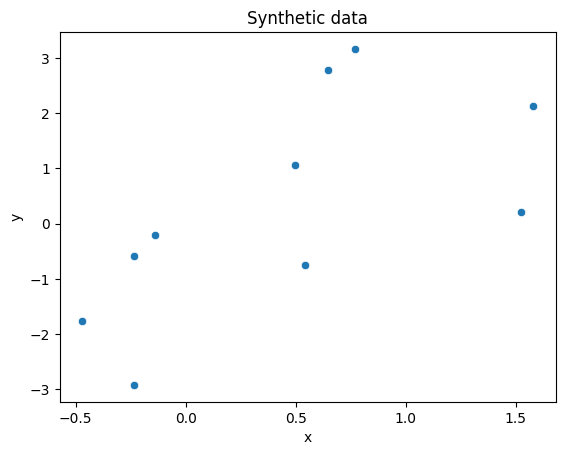

In [7]:
plt.figure()
sns.scatterplot(x=x, y=y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Synthetic data")
plt.show()

In [8]:
mu_0 = np.array([0, 0])
Sigma_0 = np.array([[1, 0], [0, 1]])

precision_prior = np.linalg.inv(Sigma_0)
precision_likelihood = (1 / sigma**2) * (X_design.T @ X_design)
precision_posterior = precision_prior + precision_likelihood

Sigma_post = np.linalg.inv(precision_posterior)
mu_post = Sigma_post @ ((1 / sigma**2) * X_design.T @ y)

print("Posterior Mean (mu_post):")
print(mu_post)
print("\nPosterior Covariance (Sigma_post):")
print(Sigma_post)


Posterior Mean (mu_post):
[-0.0761337   0.94048095]

Posterior Covariance (Sigma_post):
[[ 0.32987251 -0.13797563]
 [-0.13797563  0.43111504]]


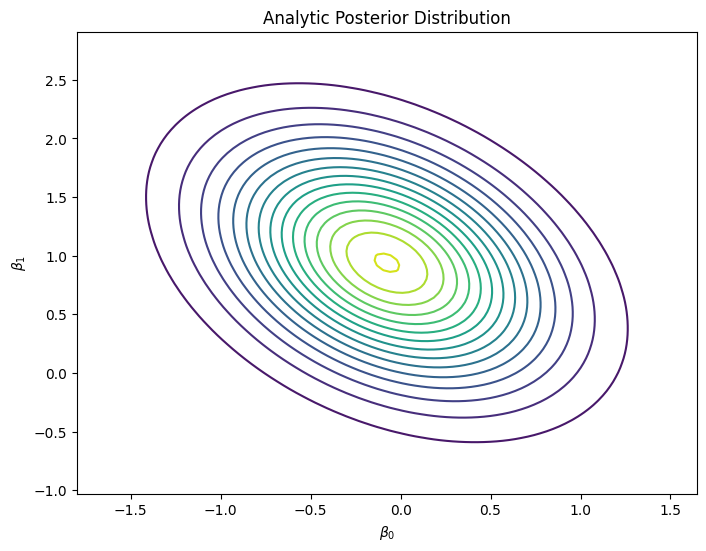

In [9]:


beta0_vals = np.linspace(mu_post[0] - 3 * np.sqrt(Sigma_post[0, 0]), mu_post[0] + 3 * np.sqrt(Sigma_post[0, 0]), 100)
beta1_vals = np.linspace(mu_post[1] - 3 * np.sqrt(Sigma_post[1, 1]), mu_post[1] + 3 * np.sqrt(Sigma_post[1, 1]), 100)
B0, B1 = np.meshgrid(beta0_vals, beta1_vals)
pos = np.dstack((B0, B1))
rv = multivariate_normal(mu_post, Sigma_post)

plt.figure(figsize=(8, 6))
plt.contour(B0, B1, rv.pdf(pos), levels=15, cmap='viridis')
plt.title('Analytic Posterior Distribution')
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$')
plt.show()


### Fullrank VI

In [10]:
with pm.Model() as model:
    beta = pm.MvNormal('beta', mu=mu_0, cov=Sigma_0, shape=2)
    
    mu = pm.math.dot(X_design, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    fullrank_advi = pm.fit(method='fullrank_advi', n=10000, random_seed=RANDOM_SEED)
    
    trace_fullrank = fullrank_advi.sample(1000, random_seed=RANDOM_SEED)



Output()

Finished [100%]: Average Loss = 20.608


In [11]:
az.summary(trace_fullrank, var_names=['beta'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.053,0.670,-1.149,1.346,0.021,0.016,1049.0,916.0,NaN
beta[1],0.919,0.778,-0.545,2.410,0.024,0.017,1043.0,866.0,NaN


In [12]:
beta_samples = trace_fullrank.posterior['beta'].stack(samples=("chain", "draw")).values.T
beta_samples

array([[ 0.25215376,  1.19637039],
       [-0.01234775,  0.09188317],
       [ 0.96232027,  0.65764331],
       ...,
       [ 0.84615896,  1.49604261],
       [-0.01086251,  0.78604508],
       [ 0.4142    ,  1.63222238]])

In [13]:
q_mu_fullrank = beta_samples.mean(axis=0)
q_cov_fullrank = np.cov(beta_samples, rowvar=False)

In [14]:
q_mu_fullrank, q_cov_fullrank

(array([-0.05323407,  0.91909082]),
 array([[ 0.44870092, -0.1967501 ],
        [-0.1967501 ,  0.60464509]]))

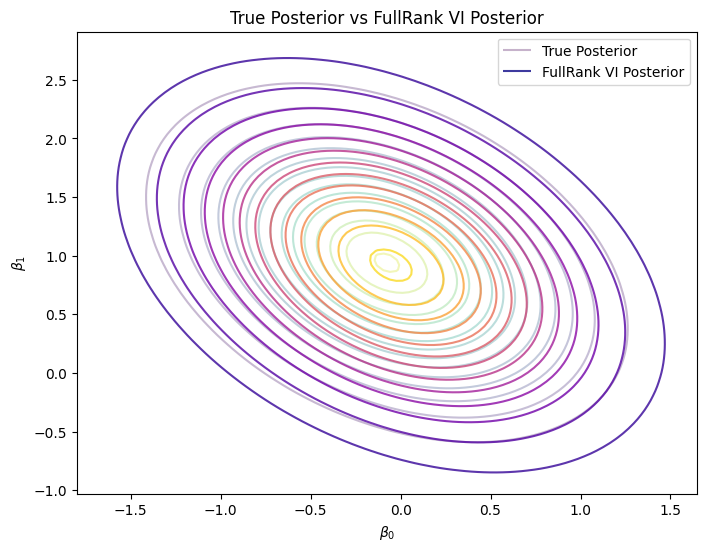

In [15]:
beta0_vals = np.linspace(mu_post[0] - 3 * np.sqrt(Sigma_post[0, 0]), mu_post[0] + 3 * np.sqrt(Sigma_post[0, 0]), 100)
beta1_vals = np.linspace(mu_post[1] - 3 * np.sqrt(Sigma_post[1, 1]), mu_post[1] + 3 * np.sqrt(Sigma_post[1, 1]), 100)
B0, B1 = np.meshgrid(beta0_vals, beta1_vals)
pos = np.dstack((B0, B1))

rv_true = multivariate_normal(mu_post, Sigma_post)

rv_fullrank = multivariate_normal(q_mu_fullrank, q_cov_fullrank)

#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))
cntr1 = ax.contour(B0, B1, rv_true.pdf(pos), levels=15, cmap='viridis', alpha=0.3)
#CS1.collections[0].set_label('True Posterior')
cntr2 = ax.contour(B0, B1, rv_fullrank.pdf(pos), levels=15, cmap='plasma', alpha=0.8)
# CS2.collections[0].set_label('FullRank ADVI Posterior')
# cntr1 = ax.contour(X, Y, Z1, colors='k')
# cntr2 = ax.contour(X, Y, Z2, colors='C0')
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
plt.title('True Posterior vs FullRank VI Posterior')
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$')
plt.legend([h1[0], h2[0]], ['True Posterior', 'FullRank VI Posterior'])
plt.show()


### MeanField

Output()

Finished [100%]: Average Loss = 20.631


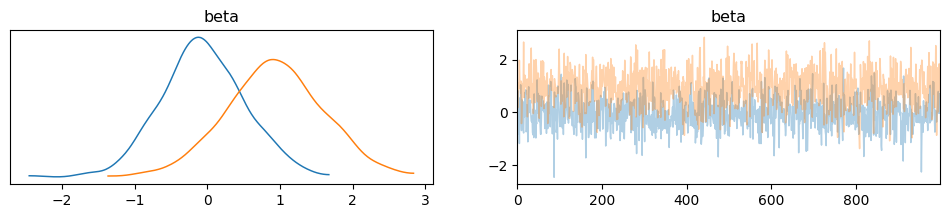

In [16]:


with pm.Model() as model:
    beta = pm.MvNormal('beta', mu=mu_0, cov=Sigma_0, shape=2)
    
    mu = pm.math.dot(X_design, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    mean_field = pm.fit(method='advi', n=10000, random_seed=RANDOM_SEED)
    
    trace_mean_field = mean_field.sample(1000, random_seed=RANDOM_SEED)

az.plot_trace(trace_mean_field, var_names=['beta'])
plt.show()


In [17]:
trace_mean_field.posterior

<xarray.Dataset> Size: 20kB
Dimensions:     (chain: 1, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int32 4B 0
  * draw        (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int32 8B 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 16kB 0.1994 1.314 ... 1.787
Attributes:
    created_at:                 2024-07-14T10:06:16.593055+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.0

Variational Mean (q_mu):
[-0.06519026  0.92962017]

Variational Std (q_sigma):
[0.58003361 0.67217494]


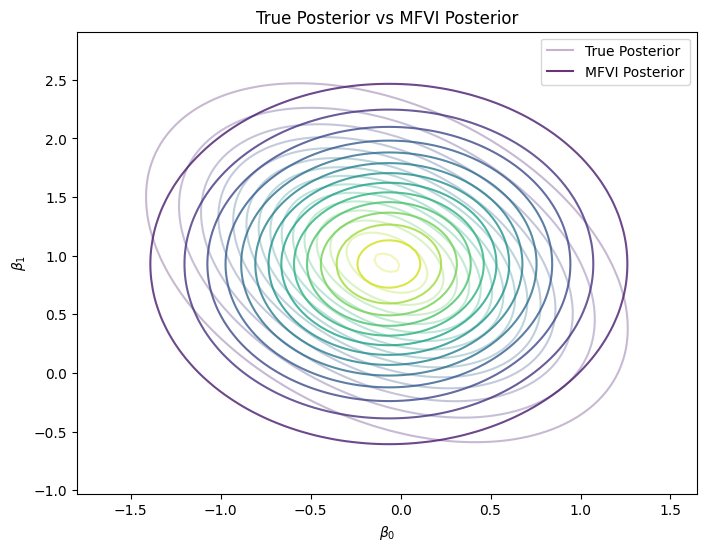

In [18]:
beta_samples = trace_mean_field.posterior['beta'].stack(samples=("chain", "draw")).values.T

q_mu = beta_samples.mean(axis=0)
q_sigma = beta_samples.std(axis=0)

print("Variational Mean (q_mu):")
print(q_mu)
print("\nVariational Std (q_sigma):")
print(q_sigma)

beta0_vals = np.linspace(mu_post[0] - 3 * np.sqrt(Sigma_post[0, 0]), mu_post[0] + 3 * np.sqrt(Sigma_post[0, 0]), 100)
beta1_vals = np.linspace(mu_post[1] - 3 * np.sqrt(Sigma_post[1, 1]), mu_post[1] + 3 * np.sqrt(Sigma_post[1, 1]), 100)
B0, B1 = np.meshgrid(beta0_vals, beta1_vals)
pos = np.dstack((B0, B1))

rv_true = multivariate_normal(mu_post, Sigma_post)

rv_variational = multivariate_normal(q_mu, np.diag(q_sigma**2))

plt.figure(figsize=(8, 6))
cntr1 = plt.contour(B0, B1, rv_true.pdf(pos), levels=15, cmap='viridis', alpha=0.3)
cntr2 = plt.contour(B0, B1, rv_variational.pdf(pos), levels=15, cmap='viridis', alpha=0.8)
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
plt.title('True Posterior vs MFVI Posterior')
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$')
plt.legend([h1[0], h2[0]], ['True Posterior', 'MFVI Posterior'])
plt.show()

# BNN

### Data

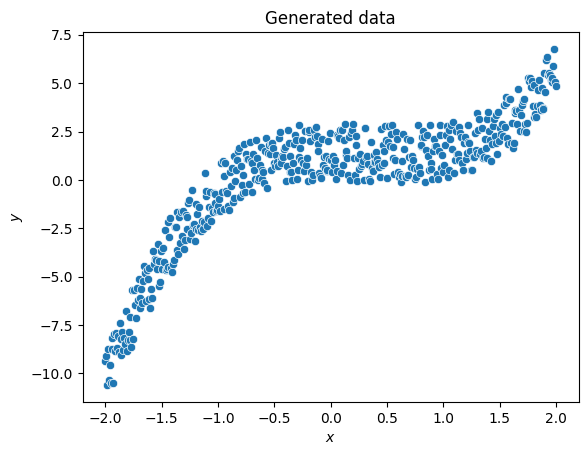

In [19]:
n = 500

x, y = generate_data(n)
x_test, y_test = generate_data(100)
train = TensorDataset(x, y)  
test = TensorDataset(x_test, y_test)
y = y.flatten()
y_test = y_test.flatten()

plot_data(x.numpy(), y.numpy(), "Generated data")

## MFVI vs MCMC: RunTime Experiment

### MFVI

In [20]:
neural_net = construct_nn2(x, y, n_hidden_layers=1)

In [21]:
%%time

with neural_net:
    advi = pm.ADVI(random_seed=RANDOM_SEED).fit(n=30000)

Output()

Finished [100%]: Average Loss = 759.84


CPU times: total: 2.16 s
Wall time: 1min 35s


In [22]:
mfvi_trace = advi.sample(1000, random_seed=RANDOM_SEED)

In [23]:
with neural_net:
    pm.set_data(new_data={"bnn_input": x_test, "bnn_output": y_test})
    pp = pm.sample_posterior_predictive(mfvi_trace, random_seed=RANDOM_SEED)
    mfvi_trace.extend(pp)

Sampling: [out]


Output()

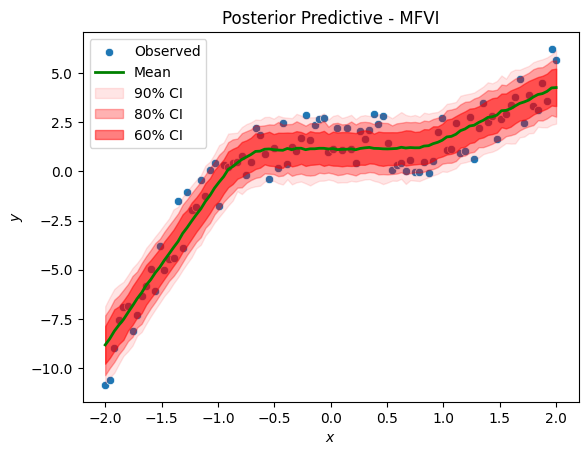

In [24]:
plot_posterior_predictive_az(x_test, y_test, mfvi_trace, "Posterior Predictive - MFVI") 

### MCMC

In [25]:
nn2 = construct_nn2(x, y, n_hidden_layers=1)


In [26]:
%%time

with nn2:
    nuts = pm.sample(1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_in, bias_in, w_out, w_bias_out]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 423 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: total: 31.3 s
Wall time: 7min 37s


In [27]:
with nn2:
    pm.set_data(new_data={"bnn_input": x_test, "bnn_output": y_test})
    pp2 = pm.sample_posterior_predictive(nuts, random_seed=RANDOM_SEED)
    nuts.extend(pp2)

Sampling: [out]


Output()

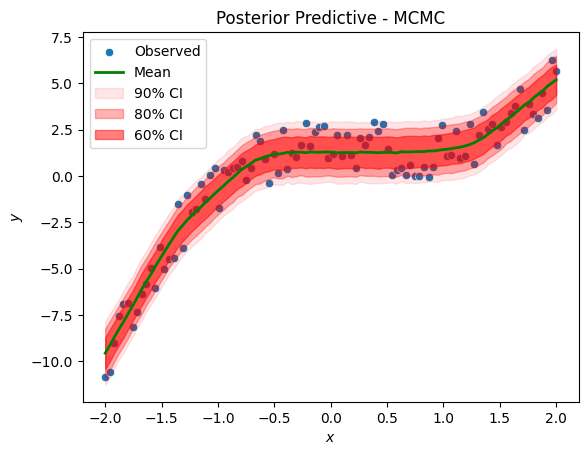

In [28]:
plot_posterior_predictive_az(x_test, y_test, nuts, "Posterior Predictive - MCMC")

## Deep MFVI vs. Shallow FullRank VI

### Full Rank VI

In [29]:
y = y.flatten()

In [30]:
neural_network = construct_nn2(x, y, n_hidden_layers=1)

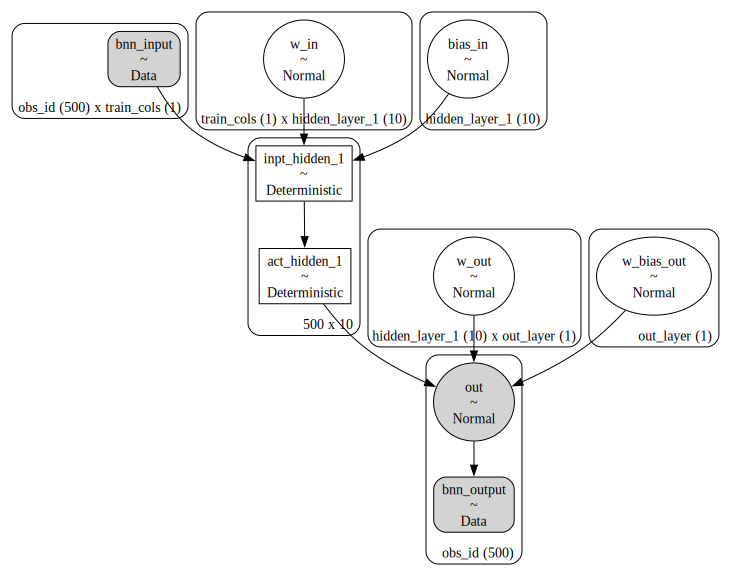

In [31]:
pm.model_to_graphviz(neural_network)

In [32]:
with neural_network:
    inference = pm.FullRankADVI(random_seed=RANDOM_SEED).fit(30000)

Output()

Finished [100%]: Average Loss = 1,020.2


In [33]:
trace = inference.sample(1000)

In [34]:
with neural_network:
    pm.set_data(new_data={"bnn_input": x_test, "bnn_output": y_test})
    posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)
    trace.extend(posterior_predictive)

Sampling: [out]


Output()

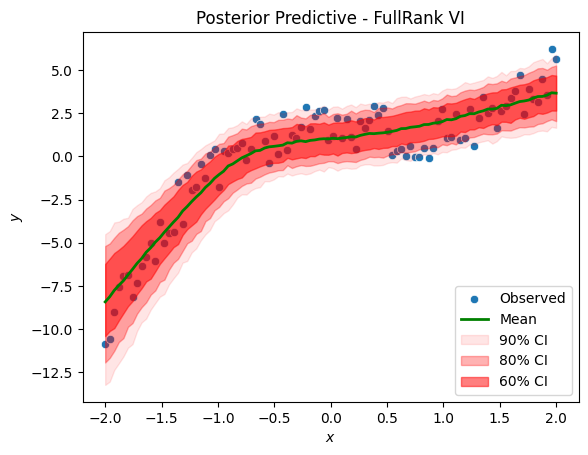

In [35]:
plot_posterior_predictive_az(x_test, y_test, trace, "Posterior Predictive - FullRank VI") 

### MFVI

In [36]:
neural_network2 = construct_nn2(x, y, n_hidden_layers=1)

with neural_network2:
    inference2 = pm.ADVI(random_seed=RANDOM_SEED).fit(30000)

Output()

Finished [100%]: Average Loss = 791.73


In [37]:
trace2 = inference2.sample(1000, random_seed=RANDOM_SEED)

In [38]:
with neural_network2:
    pm.set_data(new_data={"bnn_input": x_test, "bnn_output": y_test})
    posterior_predictive2 = pm.sample_posterior_predictive(trace2, random_seed=RANDOM_SEED)
    trace2.extend(posterior_predictive2)

Sampling: [out]


Output()

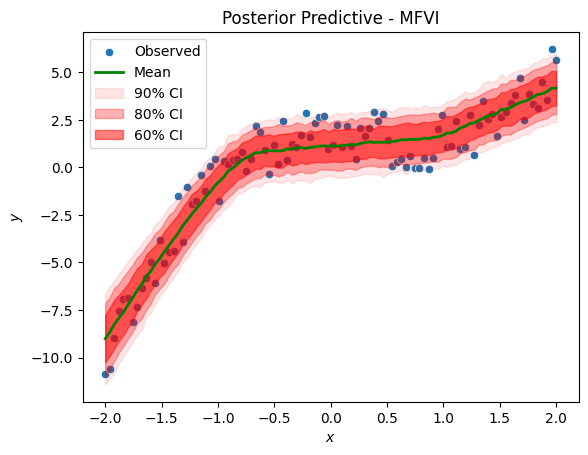

In [39]:
plot_posterior_predictive_az(x_test, y_test, trace2, "Posterior Predictive - MFVI")

### MFVI more layers

In [40]:
neural_network3 = construct_nn2(x, y, n_hidden_layers=2)

with neural_network3:
    inference3 = pm.ADVI(random_seed=RANDOM_SEED).fit(30000)

Output()

Finished [100%]: Average Loss = 1,158


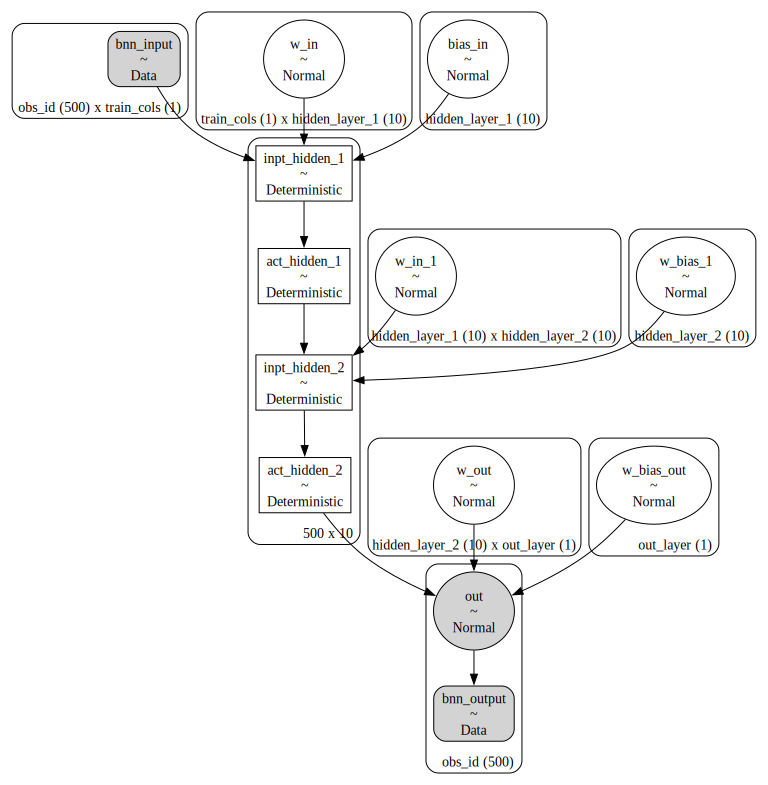

In [41]:
pm.model_to_graphviz(neural_network3)

In [42]:
trace3 = inference3.sample(1000, random_seed=RANDOM_SEED)

In [43]:
with neural_network3:
    pm.set_data(new_data={"bnn_input": x_test, "bnn_output": y_test})
    posterior_predictive3 = pm.sample_posterior_predictive(trace3, random_seed=RANDOM_SEED)
    trace3.extend(posterior_predictive3)

Sampling: [out]


Output()

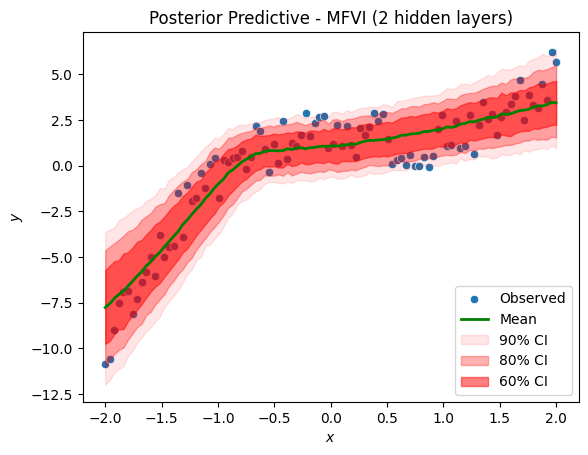

In [44]:
plot_posterior_predictive_az(x_test, y_test, trace3, "Posterior Predictive - MFVI (2 hidden layers)")